In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.dates as mdates
import seaborn as sns

In [ ]:
from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

In [ ]:
df= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Met_Estadísticos Avanzados /Proyecto Integrador/Modelo SARIMA/Sarima_total_sales_clean.csv')

In [ ]:
df.shape

(5813, 7)

In [ ]:
df.head()

,Unnamed: 0,date,state_id,cat_id,sell_price,value,total_sells
0,0,2011-01-29,CA,FOODS,4059.66,8878,36041661.48
1,1,2011-01-29,CA,HOBBIES,1470.28,1644,2417140.32
2,2,2011-01-29,CA,HOUSEHOLD,3594.69,2048,7361925.12
3,3,2011-01-30,CA,FOODS,3750.99,8593,32232257.07
4,4,2011-01-30,CA,HOBBIES,1334.13,1325,1767722.25


In [ ]:
dfh= df[["date",	"total_sells"	]][(df.cat_id=="HOBBIES") & (df.total_sells!=0) ]

Se eliminan los datos atípicos, correspondientes a los registros de ventas de los días 25 de diciembre dado que las ventas son estadísticamente cero en comparación con las ventas totales de los demás días 

In [ ]:
ind = (pd.to_datetime(dfh.date).dt.month == 12) & (pd.to_datetime(dfh.date).dt.day ==25)
dfh.loc[(dfh.total_sells < 100), "total_sells"] = dfh.total_sells.mean()


In [ ]:
dfh.head()

,date,total_sells
1,2011-01-29,2417140.32
4,2011-01-30,1767722.25
7,2011-01-31,1467471.06
10,2011-02-01,1355848.12
13,2011-02-02,1094603.84


### **ANALISIS EXPLORATORIO DE DATOS**

## 1. Graficas de la Serie Hobbies

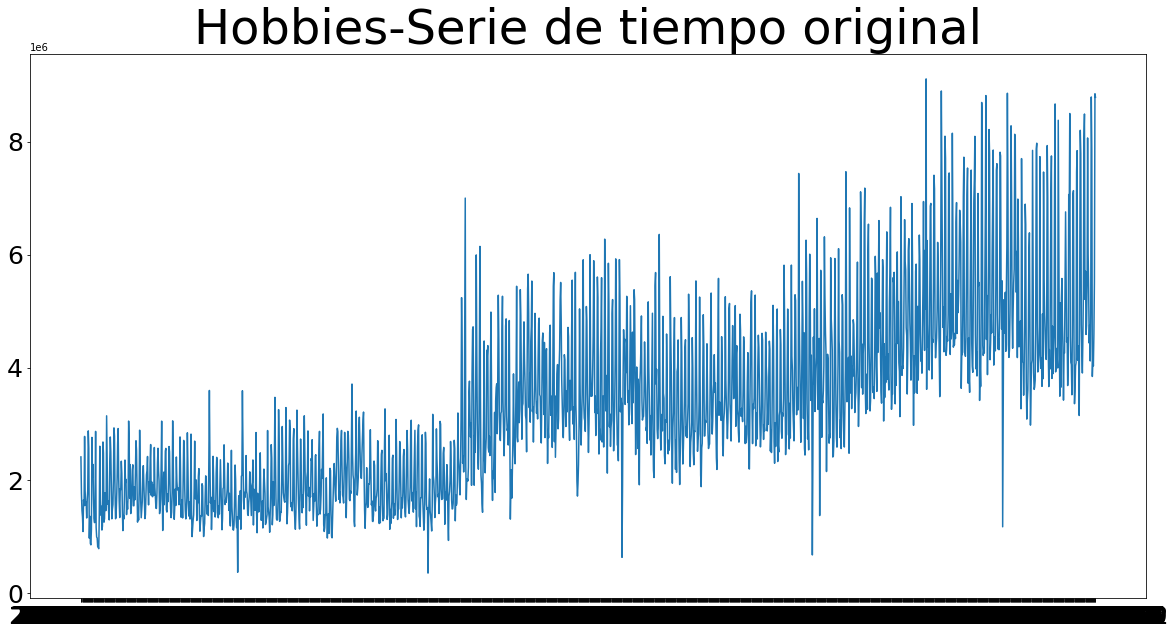

In [ ]:
plt.figure(figsize=(20, 10))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Hobbies-Serie de tiempo original',fontsize=48)
plt.plot(dfh['date'],dfh['total_sells'])
plt.show()

Gráficamente se puede observar comportamiento de tendencia creciente no lineal y varianza no constante. A continuación se propone la descomposición aditiva y multiplicativa de la serie e identificar las posibles transformaciones requeridas.

### 1.1 Descomposición de la Serie

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [ ]:
dfh["date"]= dfh.index

In [ ]:
dfh["date"] = pd.to_datetime(dfh["date"])
dfh.set_index("date", inplace = True)

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(dfh['total_sells'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(dfh['total_sells'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (30,30)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

ValueError: ignored

In [ ]:
dfh["sells_log"] = dfh["total_sells"].apply(np.log)
dfh["sells_log_diff"] = dfh["sells_log"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
df["date"] = pd.to_datetime(df["date"])
dfh.set_index("date", inplace = True)
dfh.dropna(inplace = True, axis = "rows")
dfh.head()

In [ ]:
np.isinf(dfh['sells_log_diff']).sum()

In [ ]:
test_results = adfuller(dfh["sells_log"])

print(f"ADF test statistic: {test_results[0]}")
print(f"p-value: {test_results[1]}")
print("Critical thresholds:")

for key, value in test_results[4].items():
   print(f"\t{key}: {value}")

### 1.2 Tranformaciones (Diferenciación y logaritmo)

Revisamos el comportamiento de la serie de tiempo para evaluar si es estacionaria, observando la media y varianza. Para corregir la tendencia de la serie aplicamos diferenciación, para corregir el comportamiento de la varianza aplicamos logaritmo. Posterior aplicamos el test de Dicky Fuller para comprobar su estacionariedad si p-value es < 0.05

In [1]:
dfh["sells_log"] = dfh["total_sells"].apply(np.log)
dfh["sells_log_diff"] = dfh["sells_log"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)

NameError: ignored

In [ ]:
# separar x y la y para el gráfico
x = dfh.index

y = dfh["total_sells"]
y_media = [np.mean(y) for _ in y]

y_log = dfh["sells_log"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = dfh["sells_log_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

In [ ]:
# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)
# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 15.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_media, label = "Media de la Serie Log.")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Serie Logarítmica diferenciada")
ax3.plot(x, y_log_diff_mean, label = "Media de la Serie. Log. Diff")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Comportamiento de ventas de Hobbies y sus transformaciones a lo largo de los años");

### 1.3 Comprobación de la estacionariedad de la serie test de Dicky fuller

In [ ]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie Logarítmica diferenciada"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))